In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import pickle

from cartopy.io.img_tiles import OSM
import cartopy


In [3]:
from experiments import SensorPlacement
from experiments import utilities as utils
from bayesinverse import Regression
from emissions import WK84_MASK, data_loader, GRAL, GK_MASK, transform_to_WK84

import robiplotipy.experiments.sensor_placement as plt_exp

In [4]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/sensor_placement/config.yaml"
)

exp = SensorPlacement(config_path)


sensors 0.003254249691963196
emissions 6.578021541237831
transport 45.69394147396088


In [5]:
meteo_seed = 20
n_processes = 40
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors,
    exp.sensors.get_index(),
    exp.emissions,
    n_processes=n_processes,
    seed=meteo_seed,
)


loop start 103.68816292285919
loop end 103.776875436306


In [6]:
n_mc = 200

# n_sample_list = [4, 9, 16, 20, 25]
n_sample_list = [4, 16, 25]
information_dict = {}
error_reduction_dict = {}
dof_dict = {}
sensor_ids_dict = {}
for n_sample in n_sample_list:
    print(n_sample)
    information_dict[n_sample] = []
    error_reduction_dict[n_sample] = []
    dof_dict[n_sample] = []
    sensor_ids_dict[n_sample] = []
    for i in range(n_mc):
        sensor_ids = exp.sensors.get_sample_ids(n_sample)
        time_ids = exp.transport.get_time_ids(time=100)
        reg = Regression(
            y=utils.stack_xr(
                exp.K.isel(sensor=sensor_ids, time_measurement=time_ids)
                @ exp.emissions.truth
                + exp.sensors.get_noise(n_sample).isel(time_measurement=time_ids)
            ).values,
            K=utils.stack_xr(
                exp.K.isel(sensor=sensor_ids, time_measurement=time_ids)
            ).values,
            x_prior=utils.stack_xr(exp.emissions.prior).values,
            x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
            y_covariance=utils.stack_xr(
                exp.sensors.get_covariance().isel(
                    sensor=sensor_ids, time_measurement=time_ids
                )
            ).values,
        )
        information_dict[n_sample].append(reg.get_information_content())
        error_reduction_dict[n_sample].append(reg.get_error_reduction())
        dof_dict[n_sample].append(reg.get_dof_signal())
        sensor_ids_dict[n_sample].append(sensor_ids)

4
16
25


In [7]:
# n_sample_list = [4, 9, 16, 20, 25]
best_information_dict = {}
best_error_reduction_dict = {}
best_dof_dict = {}
for n_sample in n_sample_list:
    print(n_sample)
    best_information_dict[n_sample] = []
    best_error_reduction_dict[n_sample] = []
    best_dof_dict[n_sample] = []
    exp.sensors.set_n_sensors(n_sample)
    exp.K = exp.transport.get_transport(
        exp.sensors.n_sensors,
        exp.sensors.get_index(),
        exp.emissions,
        n_processes=n_processes,
        seed=meteo_seed,
    )

    for i in range(n_mc):
        time_ids = exp.transport.get_time_ids(time=100)
        reg = Regression(
            y=utils.stack_xr(
                exp.K.isel(time_measurement=time_ids) @ exp.emissions.truth
                + exp.sensors.get_noise().isel(time_measurement=time_ids)
            ).values,
            K=utils.stack_xr(exp.K.isel(time_measurement=time_ids)).values,
            x_prior=utils.stack_xr(exp.emissions.prior).values,
            x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
            y_covariance=utils.stack_xr(
                exp.sensors.get_covariance().isel(time_measurement=time_ids)
            ).values,
        )
        best_information_dict[n_sample].append(reg.get_information_content())
        best_error_reduction_dict[n_sample].append(reg.get_error_reduction())
        best_dof_dict[n_sample].append(reg.get_dof_signal())


4
loop start 24.20327155292034
loop end 24.290537983179092
16
loop start 25.309184446930885
loop end 25.393468648195267
25
loop start 24.751424804329872
loop end 24.83943608403206


In [8]:
# Store/ load data
exp.data["information_dict"] = information_dict
exp.data["error_reduction_dict"] = error_reduction_dict
exp.data["dof_dict"] = dof_dict
exp.data["best_information_dict"] = best_information_dict
exp.data["best_error_reduction_dict"] = best_error_reduction_dict
exp.data["best_dof_dict"] = best_dof_dict
exp.data["sensor_ids_dict"] = sensor_ids_dict
# exp.pickle_data()

In [320]:
exp.load_data()
best_information_dict = exp.data["best_information_dict"]
best_dof_dict = exp.data["best_dof_dict"]
information_dict = exp.data["information_dict"]
dof_dict = exp.data["dof_dict"]
sensor_ids_dict = exp.data["sensor_ids_dict"]

KeyError: 'sensor_ids_dict'

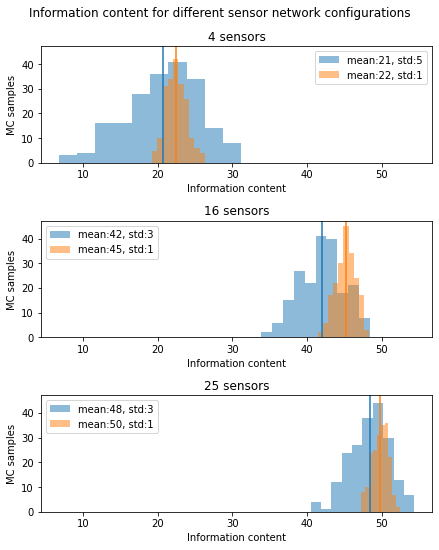

In [9]:
plt_exp.plot_hist_information(exp)


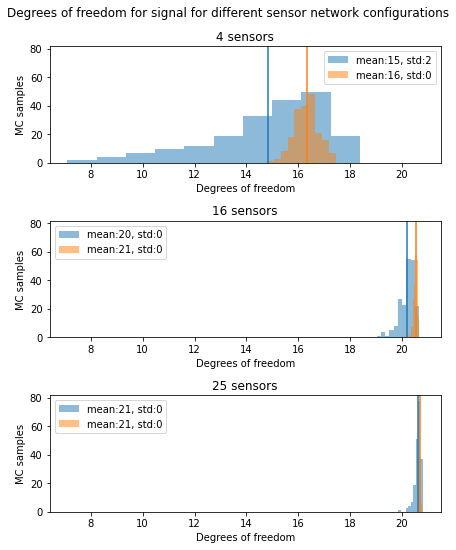

In [10]:
plt_exp.plot_hist_dof(exp)
# plt.savefig("/home/rmaiwald/results/preliminary/sensor_placement_dof")

## Analyse best positions

In [19]:
exp = SensorPlacement(config_path)

sensors 0.003287777304649353
emissions 5.858104392886162
transport 9.958735585212708


Steps
1. Identify the indices of the 10% MC runs
2. Identify the measurement positions of these runs
3. Plot the positions

In [20]:
# 1. Best MC runs
n_best = 10
n_sample = 16
mc_index = np.arange(len(information_dict[n_sample]))
# Sort by most information content
mc_index = mc_index[np.array(information_dict[n_sample]).argsort()][-n_best:]

In [22]:
# 2. Positions of the measurement stations
sensor_ids_array = np.array(sensor_ids_dict[n_sample])[mc_index]

sensor_index = exp.sensors.get_index()
x_positions = sensor_index[0][sensor_ids_array].flatten()
y_positions = sensor_index[1][sensor_ids_array].flatten()

total_positions, total_counts = np.unique(
    [x_positions, y_positions], axis=1, return_counts=True
)

In [23]:
# Convert positions to GRAL grid
total_positions[0] = total_positions[0] * GRAL.dx + GRAL.xmin
total_positions[1] = total_positions[1] * GRAL.dy + GRAL.ymin

In [24]:
# Load some background data
file_path = Path("/mnt/data/users/rmaiwald/GRAMM-GRAL/emissions/pickle_jar")

with open(file_path / "tno_gdf.pkl", "rb") as file:
    tno_gdf = pickle.load(file)

with open(file_path / "tno_df.pkl", "rb") as file:
    tno_df = pickle.load(file)

with open(file_path / "tno_point_gdf.pkl", "rb") as file:
    tno_point_gdf = pickle.load(file)


In [25]:

exp.data["tno_gdf"] = tno_gdf
exp.data["tno_df"] = tno_df

exp.data["total_counts"] = total_counts
exp.data["total_positions"] = total_positions

In [26]:
mindex = pd.MultiIndex.from_product([tno_df.columns.levels[0], ["co2_bf", "co2_ff"]])

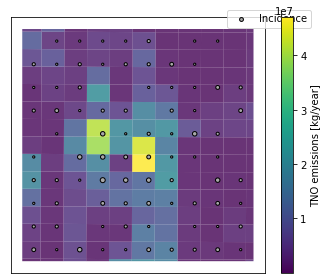

In [27]:
plt_exp.plot_sensor_counts(exp)

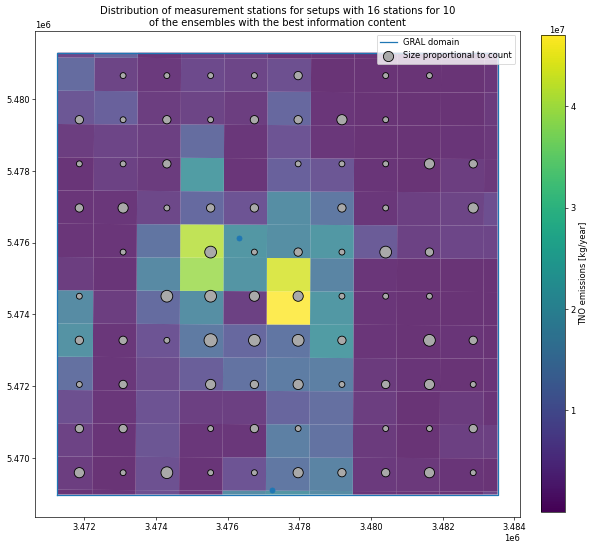

In [28]:
# 3. Plot results
plt.figure(figsize=(10, 10), dpi=60)

plt.title(
    "Distribution of measurement stations for setups with 16 stations for 10\n"
    + "of the ensembles with the best information content"
)
plt.plot(*GK_MASK.exterior.xy, label="GRAL domain")
ax = tno_gdf.clip(GK_MASK).plot(
    ax=plt.gca(),
    column=tno_df.loc[tno_gdf.clip(GK_MASK).index, mindex].sum(axis="columns"),
    alpha=0.8,
    cmap="viridis",
    legend=True,
    legend_kwds={"fraction": 0.045, "pad": 0.04, "label":"TNO emissions [kg/year]"},
)
ax = tno_point_gdf.plot(ax=ax)
plt.scatter(
    total_positions[0],
    total_positions[1],
    s=total_counts * 50,
    c="darkgrey",
    edgecolors="black",
    label="Size proportional to count",
)
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.legend(loc="upper right")


In [29]:
image = OSM()

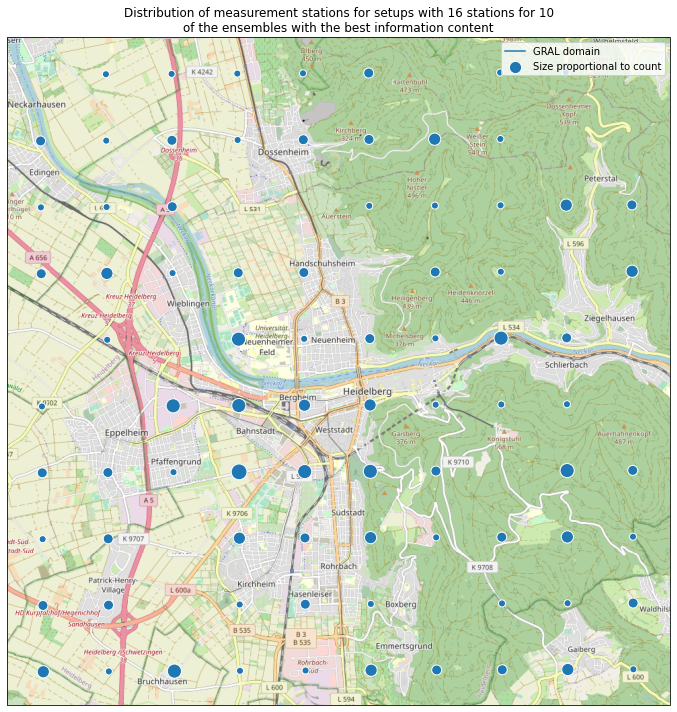

In [30]:
# 3. Plot results
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=image.crs)
ax.set_extent(np.array(WK84_MASK.bounds)[[0, 2, 1, 3]])
ax.add_image(image, 13)

plt.title(
    "Distribution of measurement stations for setups with 16 stations for 10\n"
    + "of the ensembles with the best information content"
)
ax.plot(*GK_MASK.exterior.xy, label="GRAL domain", transform=cartopy.crs.PlateCarree())
# ax = tno_gdf.clip(GK_MASK).plot(
#     ax=plt.gca(),
#     column=tno_df.loc[tno_gdf.clip(GK_MASK).index, mindex].sum(axis="columns"),
#     alpha=0.8,
#     cmap="viridis",
#     legend=True,
#     legend_kwds={"fraction": 0.045, "pad": 0.04, "label": "TNO emissions [kg/year]"},
# )
lon, lat = transform_to_WK84(
    total_positions[0], total_positions[1]
)
ax.scatter(
    lon,
    lat,
    s=total_counts * 50,
    # c="darkgrey",
    # edgecolors="black",
    c="tab:blue",
    edgecolors="white",
    label="Size proportional to count",
    transform=cartopy.crs.PlateCarree(),
)
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.legend(loc="upper right")


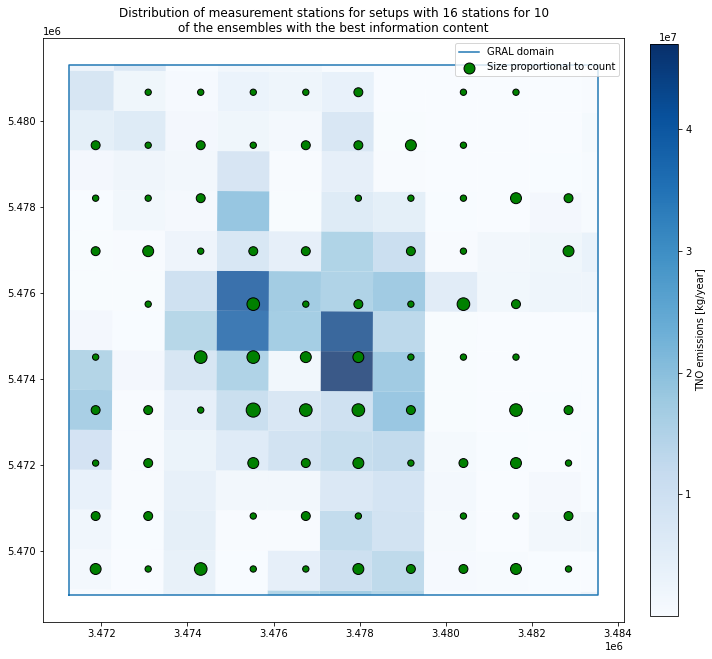

In [31]:
# 3. Plot results
plt.figure(figsize=(10, 10))

plt.title(
    "Distribution of measurement stations for setups with 16 stations for 10\n"
    + "of the ensembles with the best information content"
)
plt.plot(*GK_MASK.exterior.xy, label="GRAL domain")
ax = tno_gdf.clip(GK_MASK).plot(
    ax=plt.gca(),
    column=tno_df.loc[tno_gdf.clip(GK_MASK).index, mindex].sum(axis="columns"),
    alpha=0.8,
    cmap="Blues",
    legend=True,
    legend_kwds={"fraction": 0.045, "pad": 0.04, "label":"TNO emissions [kg/year]"},
)
plt.scatter(
    total_positions[0],
    total_positions[1],
    s=total_counts * 40,
    c="green",
    edgecolors="black",
    label="Size proportional to count",
)
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.legend(loc="upper right")


(array([2., 0., 2., 1., 1., 1., 0., 1., 0., 2.]),
 array([46.82352834, 46.98713501, 47.15074168, 47.31434836, 47.47795503,
        47.64156171, 47.80516838, 47.96877506, 48.13238173, 48.2959884 ,
        48.45959508]),
 <BarContainer object of 10 artists>)

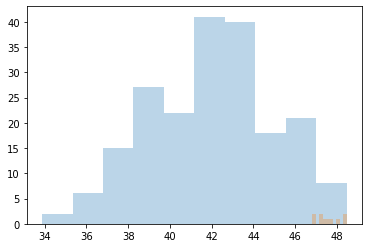

In [32]:
plt.hist(information_dict[n_sample], alpha=0.3)
plt.hist(np.array(information_dict[n_sample])[mc_index], alpha=0.3)